# Import packages and set seeds

In [2]:
! pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=4c197b787963c435e2d7fb020ec0d4ae7f6b58365d50a9e1287c634c8df749ed
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [3]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [4]:
torch.cuda.get_device_name(0)
!nvidia-smi

Fri Feb 11 00:19:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preparation
Training and Testing data is prepared from the solution file

In [9]:
data = np.load('final_data.npz') # Load data from file
keys = list(data.keys()) # all keys in the dictionary
print(keys)
nodes3D = data[keys[0]]
temperature = data[keys[1]]
boundary_nodal_coordinates3D = data[keys[2]]
boundary_solution = data[keys[3]]
# face3 = data[keys[4]]
# face4 = data[keys[5]]
# face5 = data[keys[6]]
# face6 = data[keys[7]]
print(np.shape(nodes3D))
print(np.shape(temperature))
print(np.shape(boundary_nodal_coordinates3D))
print(np.shape(boundary_solution))

['nodes', 'temperature', 'boundary_nodal_coordinates', 'boundary_solution']
(5800, 3)
(5800, 1)
(612, 3)
(612, 1)


In [10]:
# cutting useless dimension where there is nothing to predict
nodes = nodes3D[:,[0,2]]
#temperature = temperature3D[:,[0,2]]
boundary_nodal_coordinates = boundary_nodal_coordinates3D[:,[0,2]]
#boundary_solution = boundary_solution3D[:,[0,2]]
print(np.shape(nodes))
print(np.shape(temperature))
print(np.shape(boundary_nodal_coordinates))
print(np.shape(boundary_solution))

(5800, 2)
(5800, 1)
(612, 2)
(612, 1)


In [11]:
# Bounds shall be in accordance with nodes[x,y,z]
ub = nodes.max(axis=0)
lb = nodes.min(axis=0)
print(ub)
print(lb)

[0.5 1. ]
[-0.5  0. ]


# Test data
Just for comparing with the PINN predicted solution

In [12]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
#X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
#lb = X_u_test[0]  # [-1. 0.]
#ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
#u_true = usol.flatten('F')[:,None] 
X_u_test = nodes
u_true = temperature

# Training data

In [13]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

#     #Initial Condition -1 =< x =<1 and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]

#     #Boundary Condition x = -1 and 0 =< t =<1
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[-1,:][:,None]

#     #Boundary Condition x = 1 and 0 =< t =<1
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[0,:][:,None]

#     all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
#     all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]
    
    all_X_u_train = boundary_nodal_coordinates # all nodal coordinates
    all_u_train = boundary_solution # boundary condition solution
    #choose random N_u points for training
    # all_X_u_train.shape[0] = 34071
    #idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

   # X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    #u_train = all_u_train[idx,:]      #choose corresponding u
    X_u_train = all_X_u_train
    u_train = all_u_train 
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
   # X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    # No Latin Hypercube sampling. Just put all the data
    
    X_f_train = nodes # nodal coordinates or collocation points
    return X_f_train, X_u_train, u_train 


# Physics-informed neural network 

In [14]:
class Sequentialmodel(nn.Module):
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class to initialise the torch.nn.Module
              
        # Activation function
        self.activation = nn.Tanh()
        
        # Loss function
        # A help on why we are using mean reduction 
        # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        # Initialise neural network as a list using nn.Modulelist 
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0 # Initialise iteration variable
        
        #
        # Alternatively:
        
        #*all layers are callable 
    
        #Simple linear Layers
        #self.fc1 = nn.Linear(2,50)
        #self.fc2 = nn.Linear(50,50)
        #self.fc3 = nn.Linear(50,50)
        #self.fc4 = nn.Linear(50,1)
        
        
        # Xavier Normal Initialization
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self,x):
        # Forward pass
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
             
        #Alternatively:
        
        #a = self.activation(self.fc1(a))
        #a = self.activation(self.fc2(a))
        #a = self.activation(self.fc3(a))
        #a = self.fc4(a)
        
        for i in range(len(layers)-2): # last layer is not activated
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a) # linear feedforward no activation (y= mx+c)
        
        return a
        
    def loss_BC(self,x,y):
        # Boundary condition loss 
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u

    def loss_PDE(self, x_to_train_f):
        
        #nu = 0.01/np.pi
        #k = 0.01  # thermal conductivity
        #
        # 3D heat conduction with constant k and no heat generation term
        # We don't need k
        # T_xx + T_yy + T_zz = 0
        # This is also known as the Laplace equation
        
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        #u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        #u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        #u_x = u_x_t[:,[0]]
        
        #u_t = u_x_t[:,[1]]
        
        #u_xx = u_xx_tt[:,[0]]
        # This is 2D problem
        # First derivative of u w.r.t to all inputs i.e. x, y and z
        u_x_y = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        # Second derivative of u w.r.t to all inputs i.e. x, y and z                        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
        # Since there are 3 input vectors x,y and z                                                    
        u_xx = u_xx_yy[:,[0]]
        
        u_yy = u_xx_yy[:,[1]]
        
        #u_zz = u_xx_yy_zz[:,[2]]
                                        
        #f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        #loss_f = self.loss_function(f,f_hat)
        # PDE loss                                
        f = u_xx + u_yy #+ u_zz 
        
        loss_f = self.loss_function(f,f_hat) # f_hat is global variable in the main section
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_u_train, u_train, X_f_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(loss,error_vec)

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        #u_pred = np.reshape(u_pred,(256,100),order='F')
                
        return error_vec, u_pred
        
        
        
        

# Main

In [16]:
 
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

# Convert numpy arrays to tensors 
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) # Units in hidden layers
#layers = np.array([3,50,50,50,50,1]) 
#layers = np.array([3,100,100,100,100,1]) 

PINN = Sequentialmodel(layers)
       
PINN.to(device)

params = list(PINN.parameters())

# Optimisation
# L-BFGS Optimiser
# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
#                               max_iter = 5000, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-05, 
#                               tolerance_change = 1e-09, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')

# start_time = time.time()

# optimizer.step(PINN.closure)

# Adam optimiser
optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 20000

start_time = time.time()
BC_loss_array = np.zeros(max_iter)
PDE_loss_array = np.zeros(max_iter)
total_loss_array = np.zeros(max_iter)



for i in range(max_iter):
    BC_loss =  PINN.loss_BC(X_u_train, u_train) # BC loss
    PDE_loss = PINN.loss_PDE(X_f_train) # PDE loss

    total_loss = BC_loss + PDE_loss #PINN.loss(BC_loss, PDE_loss, X_f_train)
           
    optimizer.zero_grad()     # zeroes the gradient in each epoch
    
    total_loss.backward() # backprop the total loss and store in .grad()

    optimizer.step() # update parameters
    
    BC_loss_array [i] = BC_loss
    PDE_loss_array[i] = PDE_loss
    total_loss_array[i] = total_loss  
    
    if i % (max_iter/100) == 0:
        print(f" Epoch: {i+1} \t BC Loss: {BC_loss:0.4f}\t PDE Loss: {PDE_loss:0.4f} \t Loss: {total_loss:0.4f}")
    if total_loss < 1e-3:
        print(f'Loss converged in {i} Epochs ')
        break
#     if i % (max_iter/10) == 0:

#         error_vec, _ = PINN.test()

#         print(loss,error_vec)
else:
    print('Training finished')
    elapsed = time.time() - start_time                
    print('Training time: %.2f' % (elapsed))
    print(f"Final loss: {total_loss}")


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


 Epoch: 1 	 BC Loss: 0.3903	 PDE Loss: 2.3698 	 Loss: 2.7601
 Epoch: 201 	 BC Loss: 0.2447	 PDE Loss: 0.0023 	 Loss: 0.2470
 Epoch: 401 	 BC Loss: 0.2309	 PDE Loss: 0.0062 	 Loss: 0.2371
 Epoch: 601 	 BC Loss: 0.1701	 PDE Loss: 0.0105 	 Loss: 0.1806
 Epoch: 801 	 BC Loss: 0.0985	 PDE Loss: 0.0367 	 Loss: 0.1352
 Epoch: 1001 	 BC Loss: 0.0616	 PDE Loss: 0.0040 	 Loss: 0.0656
 Epoch: 1201 	 BC Loss: 0.0584	 PDE Loss: 0.0021 	 Loss: 0.0605
 Epoch: 1401 	 BC Loss: 0.0576	 PDE Loss: 0.0012 	 Loss: 0.0588
 Epoch: 1601 	 BC Loss: 0.0577	 PDE Loss: 0.0041 	 Loss: 0.0618
 Epoch: 1801 	 BC Loss: 0.0586	 PDE Loss: 0.0007 	 Loss: 0.0593
 Epoch: 2001 	 BC Loss: 0.0574	 PDE Loss: 0.0004 	 Loss: 0.0578
 Epoch: 2201 	 BC Loss: 0.0570	 PDE Loss: 0.0022 	 Loss: 0.0592
 Epoch: 2401 	 BC Loss: 0.0566	 PDE Loss: 0.0002 	 Loss: 0.0568
 Epoch: 2601 	 BC Loss: 0.0565	 PDE Loss: 0.0006 	 Loss: 0.0571
 Epoch: 2801 	 BC Loss: 0.0575	 PDE Loss: 0.0005 	 Loss: 0.0580
 Epoch: 3001 	 BC Loss: 0.0567	 PDE Loss: 0.000

In [ ]:
#solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

In [ ]:
# Detach loss tensors
#print(np.shape(total_loss_array))
#print(total_loss_array)
#print(BC_loss_array)
#print(PDE_loss_array)
#print(np.array_equal(PDE_loss_array,BC_loss_array))

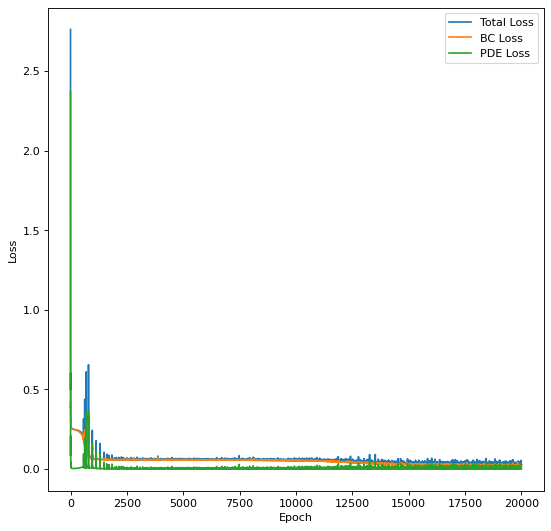

In [17]:
plt.figure(1,figsize=(8, 8), dpi=80)

iter_array = np.arange(0,max_iter)
plt.plot(iter_array,total_loss_array)
plt.plot(iter_array,BC_loss_array)
plt.plot(iter_array, PDE_loss_array)
plt.legend(['Total Loss','BC Loss','PDE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_20000_Epoch.jpg',dpi=150)

(5800, 1)


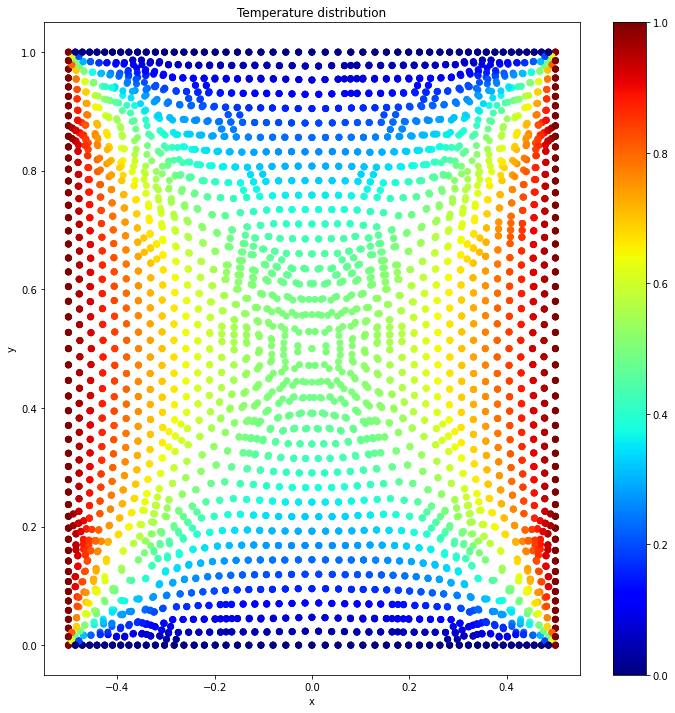

In [19]:
print(np.shape(u_pred))
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)#, projection='3d')
sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature, cmap=cm.jet)
plt.colorbar(sc)
plt.xlabel('x')
plt.ylabel('y')
#ax.set_zlabel('z')
plt.title('Temperature distribution')
plt.savefig('Exact.jpg', dpi = 200)

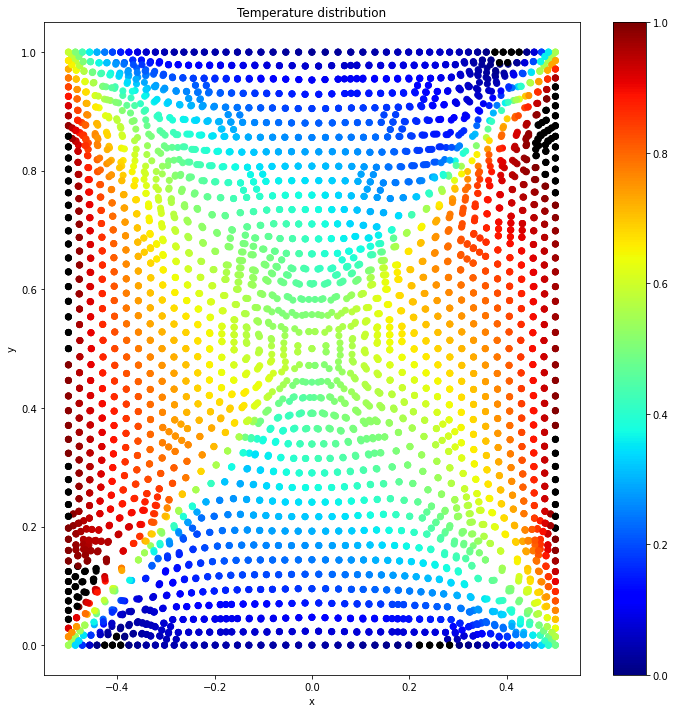

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)#, projection='3d')
sc = ax.scatter(nodes[:,0], nodes[:,1], c = u_pred, cmap=cm.jet, vmin=0, vmax=1)
plt.colorbar(sc)
sc.cmap.set_under('k')
sc.cmap.set_over('k')
plt.xlabel('x')
plt.ylabel('y')
#ax.set_zlabel('z')
plt.title('Temperature distribution')
plt.savefig('PINN_predicted.jpg', dpi = 200)

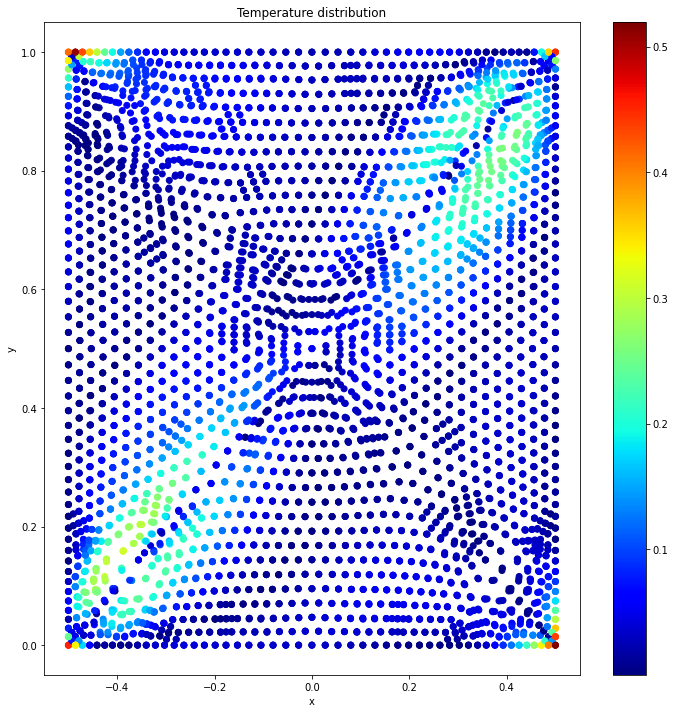

In [22]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)#, projection='3d')
 
sc = ax.scatter(nodes[:,0], nodes[:,1], c = abs(u_pred-temperature), cmap=cm.jet)
plt.colorbar(sc)
#sc.cmap.set_under('k')
#sc.cmap.set_over('k')
plt.xlabel('x')
plt.ylabel('y')
#ax.set_zlabel('z')
plt.title('Temperature distribution')
plt.savefig('absolute-error.jpg', dpi = 200)